In [ ]:
'''
This notebook is used to process RCM data in NETCDF format

What it does:
- Clip to area of interest
- Reproject data to a regular geographical 2D grid
- Convert units for SWAT+

Data details:
    RCM from 5 RCMs CORDEX-SAM44
    For baseline period and future projection[rcp 4.5 & rcp 8.5] (1981-2005 & 2076-2100)
    
** Notes:
- This script will deal with precipitation and temperature data, but it can be adjusted for other variables
- SWAT+ Can also use Relative Humidity, Solar Radiation, and Wind Speed if Penmann-Monteith equation is used to calculate PET
- For this model, the Hargreaves method was chosen to calculate PET
- Orginal RCM NETCDF Files are stored in a Pickle - This is done to save space, however, you may need to adapt your code to read the NETCDF files directly from a folder
- Data from e.g., ISIMIP, does not require reprojection, so the script can be edited to skip that step


'''
import xarray as xr
import os
import rioxarray
import numpy as np
from pyproj import Proj, transform,CRS, Transformer
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import pickle

os.chdir('..') # Changing to main SWATPlusForCRIDA

In [2]:
# Defining Models, experiments, variables and periods
# This will be useful to mantain order, read and save files

model_list=["SAM_44_RCA4_EC_EARTH",
            "SAM_44_RCA4_GFDL",
            "SAM_44_RCA4_HadGEM2",
            "SAM_44_RCA4_IPSL",
            "SAM_44_RCA4_MIROC5"]

experiment_list=["historical",
                 "rcp45",
                 "rcp85"]

period_list=["1981_2005","2076_2100"]

variable_list=["pr",
               "tasmax",
               "tasmin"]

# Define area of interest
# This area covers the part country of Bolivia, where the case Study is located
lat_min=-20
lat_max=-14
lon_min=-70
lon_max=-67

In [3]:
# Open pickles, loop through dictionaries, clip, reproject and save into new netcdfs
original_data_path = "data/CaseStudy/data/climate_data/RCM/original"
data_path = "data/CaseStudy/data/climate_data/RCM"
file_ext = "_nc.pkl"

for experiment in experiment_list:
    file = f"{original_data_path}/{experiment}{file_ext}"
    with open(file, "rb") as f:                             # Opening pickle with dictionary of NETCDF for each experiment, model and variable
        loaded_netcdf_dict = pickle.load(f)
        for model in model_list:
            for variable in variable_list:
                ds = loaded_netcdf_dict[model][variable].compute()
                ds=ds.where(
                (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) & 
                (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max),
                drop=True)
                
                
                #Getting the 2D arrays
                lat=ds["lat"].values
                lon=ds["lon"].values
                time=ds["time"].values

                            #Create a target grid to set the new values on geographic coordinates
                lat_n=np.linspace(lat.min(),lat.max(),num=lat.shape[0])
                lon_n=np.linspace(lon.min(),lon.max(),num=lon.shape[1])

                lon_n_gr,lat_n_gr=np.meshgrid(lon_n,lat_n)

                #Creating empty 3D array to store regridded values for each day of the timeseries
                data_carrier=np.empty((len(time),len(lat_n),len(lon_n)))

                for t in range(len(time)):
                    data_on_t=ds[variable].isel(time=t).values
                    #Interpolation onto the new grid
                    var_int=griddata((lon.flatten(),lat.flatten()),data_on_t.flatten(),(lon_n_gr,lat_n_gr),method='linear')
                    
                    #Storing in datacube
                    data_carrier[t,:,:]=var_int

                ds_new = xr.Dataset(
                    {
                        variable: (['time', 'lat', 'lon'], data_carrier)
                    },
                    coords={
                        'time': time,
                        'lat': lat_n,
                        'lon': lon_n
                    }
                )
                save_folder = f"{data_path}/repr/{experiment}/{model}"
                os.makedirs(save_folder, exist_ok=True)
                
                new_file = f"{save_folder}/{model}_{variable}_{experiment}.nc"
                ds_new.to_netcdf(new_file)
                print(f"{new_file} Saved Correctly")

data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_EC_EARTH/SAM_44_RCA4_EC_EARTH_pr_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_EC_EARTH/SAM_44_RCA4_EC_EARTH_tasmax_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_EC_EARTH/SAM_44_RCA4_EC_EARTH_tasmin_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_GFDL/SAM_44_RCA4_GFDL_pr_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_GFDL/SAM_44_RCA4_GFDL_tasmax_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_GFDL/SAM_44_RCA4_GFDL_tasmin_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_HadGEM2/SAM_44_RCA4_HadGEM2_pr_historical.nc Saved Correctly
data/CaseStudy/data/climate_data/RCM/repr/historical/SAM_44_RCA4_HadGEM2/SAM_44_RCA4_HadGEM2_tasmax_historical.nc 

c:\Users\joset\anaconda3\envs\jopato_env\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'Mean daily tasmin - SAM_44_RCA4_MIROC5 - rcp85 - 2076_2100')

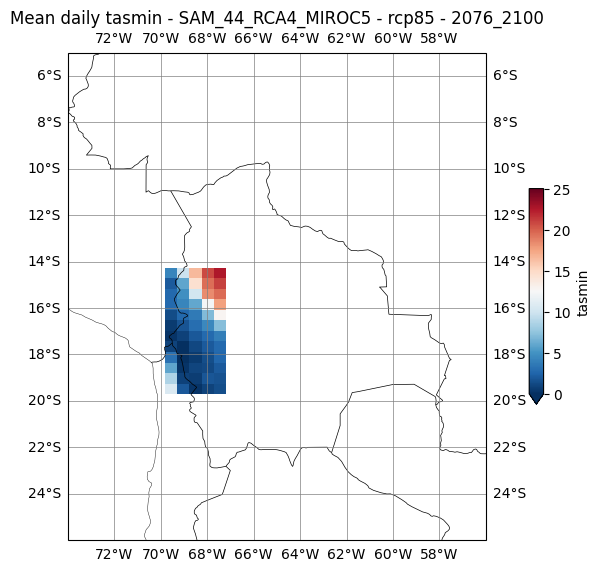

In [ ]:
# Plot check with last processed netcdf
'''
This block can be updated to read the already processed data and plot any variable from any model and experiment
Just read the NETCDF files produced above
'''
plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_extent([-74, -56, -26, -5], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                 xlocs=range(-180,180,2), ylocs=range(-90,90,2))
ax.coastlines(resolution='50m', linewidth=0.3, color='black')
(ds_new[variable].mean(dim="time")-273.15).plot(ax=ax,cmap="RdBu_r",    cbar_kwargs={
                                                                                'shrink': 0.4,         # Adjust size of the colorbar
                                                                                'aspect': 15,          # Make it thinner or thicker
                                                                                'label': variable,   # Optional label
                                                                                'pad': 0.08            # Space between plot and colorbar
                                                                            },
                                                vmin=0,vmax=25)

ax.add_feature(cartopy.feature.BORDERS, color='black',zorder=1,
                   linewidth=0.5, edgecolor='black')
ax.set_title(f"Mean daily {variable} - {model} - {experiment} - {period_list[1]}")